In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import models
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/sleathers/anaconda3/envs/explainable_ood/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize image pixel values
])
train_dataset = torchvision.datasets.CIFAR10(root='/data', train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='/data', train=False, download=False, transform=transform)

batch_size = 125
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # Flatten the output of convolutional layers
            nn.Linear(256 * 4 * 4, 512), # Adjust input features based on image size and pooling
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Instantiate the model
net = SimpleCNN(num_classes=10)
net.to(device)

Using device: cuda


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    running_accuracy = 0.0
    num_batches = len(train_loader)
    for i, data in enumerate(train_loader, start=1):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_accuracy += (outputs.argmax(dim=1) == labels).float().mean().item()
        #print(i)
        if i % num_batches == 0:    # print every check mini-batches
            print(f'Epoch: {epoch}\nLoss: {running_loss / num_batches:.4f}\nAccuracy: {running_accuracy / num_batches * 100:.2f}%\n----------------')
            running_loss = 0.0
            running_accuracy = 0.0

print('Finished Training')
torch.save(net.state_dict(), '/models/cifar_torchvision.pt')

Epoch: 0
Loss: 2.2792
Accuracy: 14.85
---------------
Epoch: 1
Loss: 2.0680
Accuracy: 26.72
---------------
Epoch: 2
Loss: 1.8469
Accuracy: 34.02
---------------
Epoch: 3
Loss: 1.6748
Accuracy: 39.85
---------------
Epoch: 4
Loss: 1.5541
Accuracy: 43.77
---------------
Epoch: 5
Loss: 1.4746
Accuracy: 46.66
---------------
Epoch: 6
Loss: 1.4131
Accuracy: 48.86
---------------
Epoch: 7
Loss: 1.3619
Accuracy: 50.81
---------------
Epoch: 8
Loss: 1.3151
Accuracy: 52.65
---------------
Epoch: 9
Loss: 1.2709
Accuracy: 54.54
---------------
Epoch: 10
Loss: 1.2290
Accuracy: 56.24
---------------
Epoch: 11
Loss: 1.1885
Accuracy: 57.73
---------------
Epoch: 12
Loss: 1.1499
Accuracy: 59.18
---------------
Epoch: 13
Loss: 1.1128
Accuracy: 60.67
---------------
Epoch: 14
Loss: 1.0779
Accuracy: 61.95
---------------
Epoch: 15
Loss: 1.0447
Accuracy: 63.17
---------------
Epoch: 16
Loss: 1.0130
Accuracy: 64.41
---------------
Epoch: 17
Loss: 0.9827
Accuracy: 65.52
---------------
Epoch: 18
Loss: 0.95

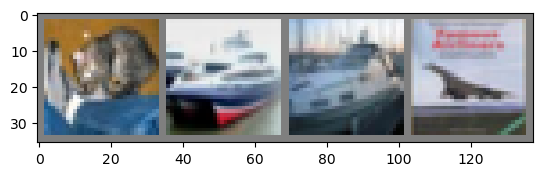

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [16]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = dataiter.__next__()
images, labels = images[0:4], labels[0:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [17]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

In [18]:
net.eval()

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [19]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )

    return tensor_attributions

Computes gradients with respect to class ind and transposes them for visualization purposes.

In [21]:
saliency = Saliency(net)
grads = saliency.attribute(input.to(device), target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

Applies integrated gradients attribution algorithm on test image. Integrated Gradients computes the integral of the gradients of the output prediction for the class index ind with respect to the input image pixels. More details about integrated gradients can be found in the original paper: https://arxiv.org/abs/1703.01365

In [24]:
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input.to(device), baselines=(input * 0).to(device), return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0439], device='cuda:0', dtype=torch.float64)


Below we demonstrate how to use integrated gradients and noise tunnel with smoothgrad square option on the test image. Noise tunnel with smoothgrad square option adds gaussian noise with a standard deviation of stdevs=0.2 to the input image nt_samples times, computes the attributions for nt_samples images and returns the mean of the squared attributions across nt_samples images.

In [26]:
ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input.to(device), baselines=(input * 0).to(device), nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

Applies DeepLift on test image. Deeplift assigns attributions to each input pixel by looking at the differences of output and its reference in terms of the differences of the input from the reference.

In [27]:
dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input.to(device), baselines=(input * 0).to(device))
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

/home/sleathers/anaconda3/envs/explainable_ood/lib/python3.12/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Original Image
Predicted: plane  Probability: 0.9536359310150146


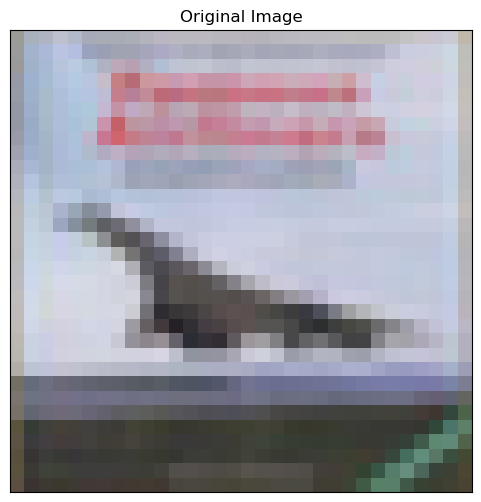

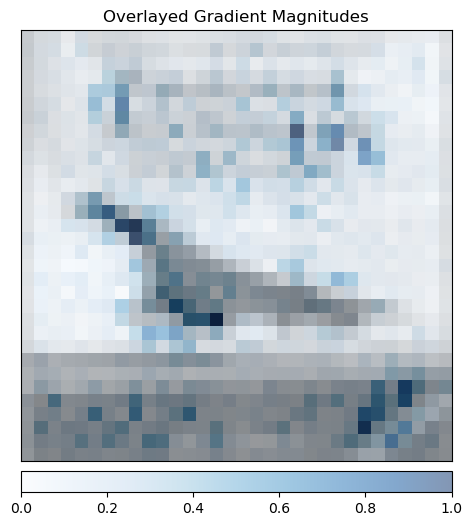

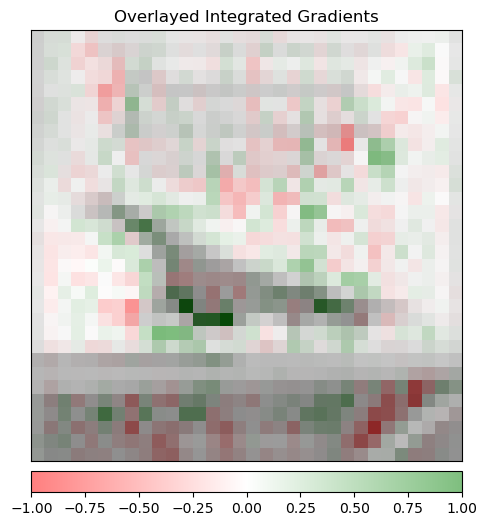

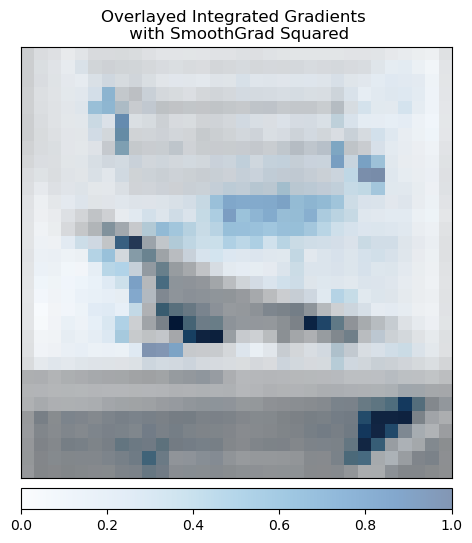

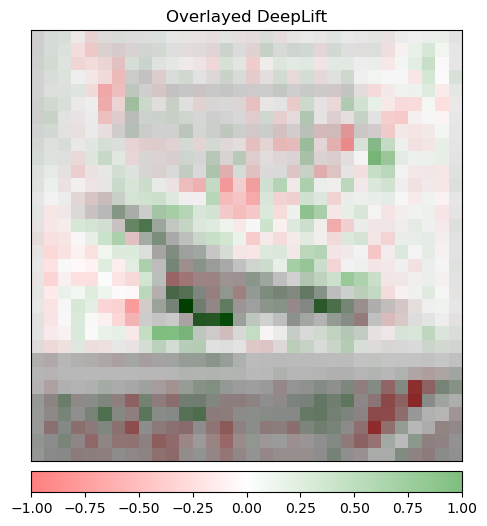

In [33]:
print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Instantiate the model
net = SimpleCNN(num_classes=10)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Using device: cuda


Want to convert training loop to rank by cosine similiarity and do updates in the epoch on reconfigured batches from lowest to highest. Inspired by: Angles Don't Lie --https://arxiv.org/pdf/2506.02281

In [5]:
# track training and loss
acc = []
loss = []

cosine_similarity = nn.CosineSimilarity(dim=1)
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    running_accuracy = 0.0
    num_batches = len(train_loader)
    label_container = torch.tensor([], device=device, dtype=torch.long)
    output_container = torch.tensor([], device=device)
    for i, data in enumerate(train_loader, start=1):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        # collect all outputs and labels for ranking prior to updating model
        label_container = torch.cat((label_container, labels), dim=0)
        output_container = torch.cat((output_container, outputs), dim=0)
        if label_container.shape[0] == train_dataset.__len__():

            # convert labels into vector for angle comparison
            label_vector = torch.zeros_like(outputs).to(device)
            for j in range(len(label_vector)):
                label_vector[j][labels[j]] += 1.0
            angles = cosine_similarity(output_container, label_vector)
            order = np.argsort(angles.detach().cpu().numpy())
            del angles
            outputs_sorted = output_container[order]
            labels_sorted = label_container[order]
            del label_container
            del output_container
            # do the training steps
            for k in range(num_batches):
                loss = criterion(outputs_sorted[k*batch_size:(k+1)*batch_size], labels_sorted[k*batch_size:(k+1)*batch_size])
                loss.backward()
                optimizer.step()
                # print statistics
                running_loss += loss.item()
                running_accuracy += (outputs.argmax(dim=1) == labels).float().mean().item()
            # delete the containers
            label_container = torch.tensor([], device=device, dtype=torch.long)
            output_container = torch.tensor([], device=device)

        #print(i)
        if i % num_batches == 0:    # print every check mini-batches
            print(f'Epoch: {epoch}\nLoss: {running_loss / num_batches:.4f}\nAccuracy: {running_accuracy / num_batches * 100:.2f}%\n----------------')
            acc.append(running_accuracy / num_batches * 100)
            loss.append(running_loss / num_batches)
            running_loss = 0.0
            running_accuracy = 0.0

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 7.62 GiB of which 40.00 MiB is free. Including non-PyTorch memory, this process has 6.66 GiB memory in use. Of the allocated memory 6.44 GiB is allocated by PyTorch, and 42.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [35]:
label_container.shape[0] == train_dataset.__len__()

True

In [36]:
output_container.shape

torch.Size([50000, 10])

In [37]:
label_container.shape

torch.Size([50000])

In [38]:
label_vector = torch.zeros_like(output_container).to(device)
for j in range(len(label_vector)):
    label_vector[j][label_container[j]] += 1.0

In [40]:
angles = cosine_similarity(output_container, label_vector)

In [43]:
order = np.argsort(angles.detach().cpu().numpy())

In [44]:
output_container[order]

tensor([[ 0.4391, -0.2090,  0.2405,  ..., -0.1127,  0.0138, -0.2520],
        [ 0.5566,  0.2180,  0.0148,  ..., -0.0958,  0.1461,  0.3886],
        [ 0.7560, -0.2151,  0.2920,  ...,  0.3213,  0.0394,  0.0269],
        ...,
        [-0.6092,  1.6787,  0.1727,  ..., -0.4324, -0.6341,  0.0801],
        [-0.4947,  2.0012, -0.2714,  ..., -0.7265, -0.2945,  0.3851],
        [-0.3690,  1.9553, -0.5027,  ..., -0.2271, -0.5554,  0.1403]],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [45]:
num_batches

400

In [46]:
batch_size

125

In [47]:
outputs_sorted = output_container[order]
labels_sorted = label_container[order]

In [48]:
for i in range(num_batches):
    print(outputs_sorted[i*batch_size:(i+1)*batch_size].shape)

torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size([125, 10])
torch.Size

In [13]:
cont = torch.zeros_like(outputs)
cont

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [14]:
for i in range(len(cont)):
    cont[i][labels[i]] += 1.0

In [15]:
cont

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [18]:
cosine_similarity(outputs, cont)

tensor([ 0.1366,  0.1858, -0.2225,  0.5976,  0.6404,  0.5793, -0.2504,  0.2168,
        -0.1392,  0.3693,  0.1488,  0.0535,  0.4582, -0.0711,  0.4801, -0.2897,
         0.2346,  0.3594,  0.2063,  0.2191,  0.1764, -0.1689,  0.3341,  0.2271,
         0.1195, -0.2138, -0.2211,  0.1054,  0.1023,  0.1963,  0.4122,  0.1680,
         0.2229,  0.6110,  0.4236,  0.3714, -0.1202, -0.0490,  0.2215, -0.2782,
         0.3965,  0.2040,  0.4807, -0.0596,  0.3464, -0.2371,  0.5867, -0.0646,
         0.2454,  0.3108, -0.2055,  0.6166,  0.3173,  0.3491, -0.4238,  0.2336,
         0.6060,  0.3610,  0.1178, -0.0326, -0.0622,  0.3939,  0.0455,  0.2815,
         0.2557,  0.2355,  0.2452, -0.2257,  0.1150, -0.2241,  0.3765,  0.1698,
        -0.3449,  0.3871,  0.3534,  0.1994,  0.1326, -0.4123, -0.4738,  0.1884,
         0.1923, -0.1199, -0.2615,  0.2354,  0.2526,  0.3501,  0.1943,  0.3832,
        -0.0239,  0.4500, -0.0269,  0.3992, -0.5087,  0.4096, -0.2466, -0.1627,
         0.6011, -0.2351,  0.3454, -0.45

In [20]:
outputs.argmax(dim=1) == labels

tensor([False, False, False,  True,  True,  True, False,  True, False,  True,
        False, False,  True, False,  True, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True, False, False, False, False, False,
         True, False,  True, False,  True, False,  True, False,  True, False,
        False,  True, False, False, False, False,  True, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False,  True,
        False,  True, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False], device='cuda:0')